# Theme 4 - Coastal Ocean Dynamics and Ecosystems
## Hypoxia on Continental Shelves
OOI Data Labs Education Nuggets

_Written by Lori Garzio, Rutgers University_

**Objective**: Demonstrate how to download dissolved oxygen data from the OOI system using the Machine-to-Machine (M2M) interface and export the data as a .csv file.

In [1]:
# Notebook Setup
import requests
import os
import re
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 1. Request Data from OOINet

* **Endurance** - Oregon Inshore Surface Mooring: Dissolved Oxygen at the seafloor (~25m depth)
    * Instrument: CE01ISSM-MFD37-03-DOSTAD000
    * Time range: 2014-06-01 to 2014-07-15
    * Delivery method:  recovered_inst
    * Data stream: dosta_abcdjm_ctdbp_instrument_recovered
    * Parameter name: dissolved_oxygen

The **request_data** function below sends data requests with inputs specified by the user to OOINet and returns the THREDDs urls where the downloaded data files can be found.

In [2]:
# enter your OOI API username and token, and directory where output .csv files are saved
API_USERNAME = ''
API_TOKEN = ''
save_dir = '/Users/lgarzio/Documents/OOI/Nuggets/'

In [3]:
def request_data(reference_designator, method, stream, start_date=None, end_date=None):
    site = reference_designator[:8]
    node = reference_designator[9:14]
    instrument = reference_designator[15:]

    # Create the request URL
    api_base_url = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv'
    data_request_url = '/'.join((api_base_url, site, node, instrument, method, stream))

    # All of the following are optional, but you should specify a date range
    params = {
        'format': 'application/netcdf',
        'include_provenance': 'true',
        'include_annotations': 'true'
    }
    if start_date:
        params['beginDT'] = start_date
    if end_date:
        params['endDT'] = end_date

    # Make the data request
    r = requests.get(data_request_url, params=params, auth=(API_USERNAME, API_TOKEN))
    data = r.json()

    # Return just the THREDDS URL
    return data['allURLs'][0]

Now, use that **request_data** function to download data for the three instruments of interest. You only need to do this once! These lines are commented out to prevent accidental re-submission of data requests.

In [4]:
# url = request_data('CE01ISSM-MFD37-03-DOSTAD000', 'recovered_inst', 'dosta_abcdjm_ctdbp_instrument_recovered',
#                    '2014-06-01T00:00:00.000Z', '2014-07-15T00:00:00.000Z')
# print('url = %s' %url)

## 2. Load Data Files

Copy the links to the THREDDs catalog above that resulted from the **request_data** function (to avoid re-requesting the data). Note: the url must be surrounded by quotations.

In [5]:
url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/lgarzio@marine.rutgers.edu/20190809T182801047Z-CE01ISSM-MFD37-03-DOSTAD000-recovered_inst-dosta_abcdjm_ctdbp_instrument_recovered/catalog.html'

The **get_data** function below:
* selects the appropriate datasets in a THREDDs catalog by selecting NetCDF files and removing collocated datasets (if provided)
* creates an empty dictionary with placeholders to populate with data just for variables of interest
* creates another dictionary to store the units for the variables of interest
* opens the dataset(s), extracts the data and units for the variables of interest and adds them to the dictionaries
* converts the data dictionary to a dataframe
* returns the dataframe and the dictionary containing the variable units. 

This type of function is most useful when working with multiple large/dense datasets, but is also fine for working with smaller datasets.

In [6]:
def get_data(url, vars):
    # Function to grab all data from specified directory
    tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
    dataset = requests.get(url).text
    ii = re.findall(r'href=[\'"]?([^\'" >]+)', dataset)
    # x = re.findall(r'(ooi/.*?.nc)', dataset)
    x = [y for y in ii if y.endswith('.nc')]
    for i in x:
        if i.endswith('.nc') == False:
            x.remove(i)
    for i in x:
        try:
            float(i[-4])
        except:
            x.remove(i)
    # dataset = [os.path.join(tds_url, i) for i in x]
    datasets = [os.path.join(tds_url, i.split('=')[-1]) for i in x]

    # remove collocated data files if necessary
    catalog_rms = url.split('/')[-2][20:]
    selected_datasets = []
    for d in datasets:
        if catalog_rms == d.split('/')[-1].split('_20')[0][15:]:
            selected_datasets.append(d)

    # create a dictionary to populate with data from the selected datasets
    data_dict = {'time': np.array([], dtype='datetime64[ns]')}
    unit_dict = {}
    for v in vars:
        data_dict.update({v: np.array([])})
        unit_dict.update({v: []})

    for sd in selected_datasets:
        ds = xr.open_dataset(sd, mask_and_scale=False)
        data_dict['time'] = np.append(data_dict['time'], ds['time'].values)
        for var in vars:
            data_dict[var] = np.append(data_dict[var], ds[var].values)
            units = ds[var].units
            if units not in unit_dict[var]:
                unit_dict[var].append(units)

    # convert dictionary to a dataframe
    df = pd.DataFrame(data_dict)

    return df, unit_dict

In [7]:
# Specify the variable(s) of interest and get the data for the three datasets
variables = ['dissolved_oxygen', 'practical_salinity', 'ctdbp_seawater_temperature']

data, units = get_data(url, variables)
print(units)

{'dissolved_oxygen': ['µmol kg-1'], 'practical_salinity': ['1'], 'ctdbp_seawater_temperature': ['ºC']}


In [8]:
# print the first few lines of the dataframe
data.head()

,time,dissolved_oxygen,practical_salinity,ctdbp_seawater_temperature
0,2014-06-01 00:00:01,107.680277,32.218832,8.257129
1,2014-06-01 00:10:01,107.298656,32.219519,8.258844
2,2014-06-01 00:20:01,108.013990,32.220135,8.259734
3,2014-06-01 00:30:01,107.564592,32.220542,8.262275
4,2014-06-01 00:40:01,108.034066,32.221145,8.266406


## Quick Data Plots
Make quick plots to make sure you downloaded the correct data.

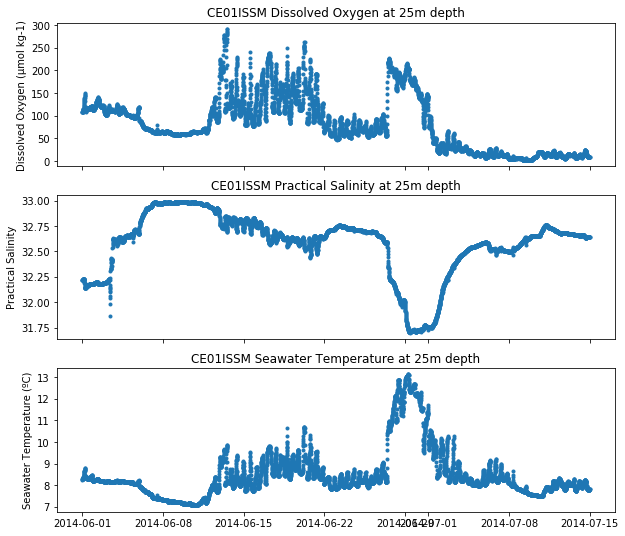

In [9]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1, sharex=True, figsize=(10,9))
ax1.plot(data['time'], data['dissolved_oxygen'], '.')
ax1.set_xlabel('')
ax1.set_ylabel('Dissolved Oxygen ({})'.format(units['dissolved_oxygen'][0]))
ax1.set_title('CE01ISSM Dissolved Oxygen at 25m depth')

ax2.plot(data['time'], data['practical_salinity'], '.')
ax2.set_xlabel('')
ax2.set_ylabel('Practical Salinity')
ax2.set_title('CE01ISSM Practical Salinity at 25m depth')

ax3.plot(data['time'], data['ctdbp_seawater_temperature'], '.')
ax3.set_xlabel('')
ax3.set_ylabel('Seawater Temperature ({})'.format(units['ctdbp_seawater_temperature'][0]))
ax3.set_title('CE01ISSM Seawater Temperature at 25m depth');

## 3. Export to csv
Since this is a relatively short time range (1.5 months), we don't need to do any subsetting and can export the full dataset

In [10]:
# rename and add units to the columns
data = data.rename(columns={'dissolved_oxygen': 'Dissolved Oxygen ({})'.format(units['dissolved_oxygen'][0]),
                           'practical_salinity': 'Practical Salinity',
                           'ctdbp_seawater_temperature': 'Seawater Temperature (deg_C)'})
# export to csv
data.to_csv(os.path.join(save_dir, 'Theme4b_CE01ISSM_dissolved_oxygen.csv'), index=False)